# **Import Library**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from keras.models import Model
from keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError
import seaborn as sns
import matplotlib.pyplot as plt
import tkinter as tk
from tkinter import ttk
import joblib

# **Get and Preprocessed The Dataset**

In [ ]:
# !pip install --upgrade gspread
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

# Open the Google Sheet by title
worksheet = gc.open("preprocessed_data").sheet1  # Replace "data" with the actual title of your Google Sheet

# Get all values from the sheet as a list of lists
data = worksheet.get_all_values()

# Convert the data to a pandas DataFrame
df = pd.DataFrame(data[1:], columns=data[0])  # Assuming the first row contains column headers
df

,URL,Perfume Name,Gender,Brand,Description,Description Blockquote,Top Notes,Middle Notes,Base Notes,Image,...,violet,soapy,coca-cola,foresty,wine,woody,sand,herbal,mineral,white floral
0,https://www.fragrantica.com/perfume/Zara/007-F...,007 Feels Like Summer Zara,for women,Zara,007 Feels Like Summer by Zara is a Aromatic Fr...,,,,,https://fimgs.net/mdimg/perfume/375x500.60102.jpg,...,0,0,0,0,0,0.671873235,0,0,0,0
1,https://www.fragrantica.com/perfume/Tauer-Perf...,02 L'Air du Desert Marocain Tauer Perfumes,for women and men,Tauer Perfumes,02 L'Air du Desert Marocain by Tauer Perfumes ...,L`Air du Desert Marocain was made as a lighter...,"Coriander, Cumin, Petitgrain, Lavender","Labdanum, Birch, Jasmine, Geranium","Amber, Cedar, Vetiver, Patchouli, Oakmoss",https://fimgs.net/mdimg/perfume/375x500.4573.jpg,...,0,0,0,0,0,1,0,0.49095,0,0
2,https://www.fragrantica.com/perfume/Rabanne/1-...,1 Million Cologne Rabanne,for men,Rabanne,1 Million Cologne by Rabanne is a Woody Spicy...,In 2008 Paco Rabanne presented masculine fragr...,,,,https://fimgs.net/mdimg/perfume/375x500.30497.jpg,...,0,0,0,0,0,0.4900177857,0,0,0,0
3,https://www.fragrantica.com/perfume/Rabanne/1-...,1 Million Eau de Toilette Collector Edition Ra...,for men,Rabanne,1 Million Eau de Toilette Collector Edition by...,,,,,https://fimgs.net/mdimg/perfume/375x500.47198.jpg,...,0,0,0,0,0,0.7943979801,0,0,0,0
4,https://www.fragrantica.com/perfume/Rabanne/1-...,1 Million Privé Rabanne,for men,Rabanne,1 Million Privé by Rabanne is a Oriental Woody...,Paco Rabanne launched 1 Million fragrance in 2...,,,,https://fimgs.net/mdimg/perfume/375x500.37698.jpg,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20331,https://www.fragrantica.com/perfume/Rasasi/Yum...,Yumn Pour Homme Rasasi,for men,Rasasi,Yumn Pour Homme by Rasasi is a Oriental Woody ...,,,,,https://fimgs.net/mdimg/perfume/375x500.92106.jpg,...,0,0,0,0,0,0.835000614,0,0.4574982247,0,0
20332,https://www.fragrantica.com/perfume/Lush/Yuzu-...,Yuzu and Cocoa Lush,for women and men,Lush,Yuzu and Cocoa by Lush is a Aromatic fragrance...,,,,,https://fimgs.net/mdimg/perfume/375x500.60097.jpg,...,0,0,0,0,0,0,0,0,0,0
20333,https://www.fragrantica.com/perfume/Lush/Zesty...,Zesty Lush,for women and men,Lush,Zesty by Lush is a fragrance for women and men...,"Zesty body spray is a fresh, fragrant burst of...",,,,https://fimgs.net/mdimg/perfume/375x500.93841.jpg,...,0,0,0,0,0,0,0,0,0,0
20334,https://www.fragrantica.com/perfume/Rasasi/Zin...,Zinobia Rasasi,for women,Rasasi,Zinobia by Rasasi is a Oriental Floral fragran...,,,,,https://fimgs.net/mdimg/perfume/375x500.19664.jpg,...,0,0,0,0,0,0,0,0,0,0


# **Feature Selection**

In [ ]:
df.columns

Index(['URL', 'Perfume Name', 'Gender', 'Brand', 'Description',
       'Description Blockquote', 'Top Notes', 'Middle Notes', 'Base Notes',
       'Image', 'Rating Value', 'Best Rating', 'Votes', 'fresh', 'coconut',
       'cinnamon', 'smoky', 'conifer', 'brown scotch tape', 'rose',
       'tennis ball', 'almond', 'metallic', 'Champagne', 'animalic', 'iris',
       'lactonic', 'fresh spicy', 'sake', 'patchouli', 'nutty', 'paper',
       'tobacco', 'terpenic', 'ozonic', 'marine', 'chocolate', 'clay',
       'caramel', 'rubber', 'savory', 'vodka', 'coffee', 'green', 'salty',
       'bitter', 'mossy', 'cherry', 'anis', 'alcohol', 'plastic', 'amber',
       'oud', 'beeswax', 'sweet', 'yellow floral', 'powdery', 'honey', 'rum',
       'aquatic', 'musky', 'aldehydic', 'camphor', 'floral', 'cacao', 'citrus',
       'asphault', 'sour', 'Pear', 'lavender', 'earthy', 'oily', 'leather',
       'whiskey', 'soft spicy', 'vinyl', 'industrial glue', 'balsamic',
       'warm spicy', 'tropical', 'canna

In [ ]:
columns_to_convert = ['fresh', 'coconut', 'cinnamon', 'smoky', 'conifer', 'brown scotch tape', 'rose',
       'tennis ball', 'almond', 'metallic', 'Champagne', 'animalic', 'iris',
       'lactonic', 'fresh spicy', 'sake', 'patchouli', 'nutty', 'paper',
       'tobacco', 'terpenic', 'ozonic', 'marine', 'chocolate', 'clay',
       'caramel', 'rubber', 'savory', 'vodka', 'coffee', 'green', 'salty',
       'bitter', 'mossy', 'cherry', 'anis', 'alcohol', 'plastic', 'amber',
       'oud', 'beeswax', 'sweet', 'yellow floral', 'powdery', 'honey', 'rum',
       'aquatic', 'musky', 'aldehydic', 'camphor', 'floral', 'cacao', 'citrus',
       'asphault', 'sour', 'Pear', 'lavender', 'earthy', 'oily', 'leather',
       'whiskey', 'soft spicy', 'vinyl', 'industrial glue', 'balsamic',
       'warm spicy', 'tropical', 'cannabis', 'fruity', 'tuberose', 'aromatic',
       'vanilla', 'violet', 'soapy', 'coca-cola', 'foresty', 'wine', 'woody',
       'sand', 'herbal', 'mineral', 'white floral']

for column in columns_to_convert:
    df[column] = pd.to_numeric(df[column], errors='coerce')

In [ ]:
numerical_columns = df.select_dtypes(include=['float64', 'int64', 'int32']).columns
print(numerical_columns.tolist())  # Untuk menampilkan dalam bentuk list


['fresh', 'coconut', 'cinnamon', 'smoky', 'conifer', 'brown scotch tape', 'rose', 'tennis ball', 'almond', 'metallic', 'Champagne', 'animalic', 'iris', 'lactonic', 'fresh spicy', 'sake', 'patchouli', 'nutty', 'paper', 'tobacco', 'terpenic', 'ozonic', 'marine', 'chocolate', 'clay', 'caramel', 'rubber', 'savory', 'vodka', 'coffee', 'green', 'salty', 'bitter', 'mossy', 'cherry', 'anis', 'alcohol', 'plastic', 'amber', 'oud', 'beeswax', 'sweet', 'yellow floral', 'powdery', 'honey', 'rum', 'aquatic', 'musky', 'aldehydic', 'camphor', 'floral', 'cacao', 'citrus', 'asphault', 'sour', 'Pear', 'lavender', 'earthy', 'oily', 'leather', 'whiskey', 'soft spicy', 'vinyl', 'industrial glue', 'balsamic', 'warm spicy', 'tropical', 'cannabis', 'fruity', 'tuberose', 'aromatic', 'vanilla', 'violet', 'soapy', 'coca-cola', 'foresty', 'wine', 'woody', 'sand', 'herbal', 'mineral', 'white floral']


In [ ]:
columns_to_exclude = ['Rating Value', 'Best Rating', 'Votes']
# features = numerical_columns.drop(columns_to_exclude)
features = numerical_columns
features

Index(['fresh', 'coconut', 'cinnamon', 'smoky', 'conifer', 'brown scotch tape',
       'rose', 'tennis ball', 'almond', 'metallic', 'Champagne', 'animalic',
       'iris', 'lactonic', 'fresh spicy', 'sake', 'patchouli', 'nutty',
       'paper', 'tobacco', 'terpenic', 'ozonic', 'marine', 'chocolate', 'clay',
       'caramel', 'rubber', 'savory', 'vodka', 'coffee', 'green', 'salty',
       'bitter', 'mossy', 'cherry', 'anis', 'alcohol', 'plastic', 'amber',
       'oud', 'beeswax', 'sweet', 'yellow floral', 'powdery', 'honey', 'rum',
       'aquatic', 'musky', 'aldehydic', 'camphor', 'floral', 'cacao', 'citrus',
       'asphault', 'sour', 'Pear', 'lavender', 'earthy', 'oily', 'leather',
       'whiskey', 'soft spicy', 'vinyl', 'industrial glue', 'balsamic',
       'warm spicy', 'tropical', 'cannabis', 'fruity', 'tuberose', 'aromatic',
       'vanilla', 'violet', 'soapy', 'coca-cola', 'foresty', 'wine', 'woody',
       'sand', 'herbal', 'mineral', 'white floral'],
      dtype='object')

# **Build Autoecoder Model**

In [ ]:
# Encoder
encoder_input = layers.Input(shape=(len(features),))
encoder = layers.Dense(128, activation='relu')(encoder_input)
encoder = layers.Dense(64, activation='relu')(encoder)
encoder_output = layers.Dense(32, activation='relu')(encoder)

# Decoder
decoder = layers.Dense(64, activation='relu')(encoder_output)
decoder = layers.Dense(128, activation='relu')(decoder)
decoder_output = layers.Dense(len(features), activation='sigmoid')(decoder)

# Autoencoder Model
autoencoder = models.Model(inputs=encoder_input, outputs=decoder_output)
autoencoder.compile(optimizer='adam', loss=MeanSquaredError())

In [ ]:
n_splits = 10

# K-Fold Cross-Validation
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
X = df[features].values

# Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    mode='min',
    min_delta=0.0001
)

# **Extract Features and Iterate through the folds**

Fold 1: Training MSE = 0.0011, Validation MSE = 0.0013
Fold 2: Training MSE = 0.0010, Validation MSE = 0.0011
Fold 3: Training MSE = 0.0011, Validation MSE = 0.0012
Fold 4: Training MSE = 0.0010, Validation MSE = 0.0011
Fold 5: Training MSE = 0.0010, Validation MSE = 0.0010
Fold 6: Training MSE = 0.0010, Validation MSE = 0.0011
Fold 7: Training MSE = 0.0010, Validation MSE = 0.0011
Fold 8: Training MSE = 0.0010, Validation MSE = 0.0011
Fold 9: Training MSE = 0.0009, Validation MSE = 0.0010
Fold 10: Training MSE = 0.0010, Validation MSE = 0.0009


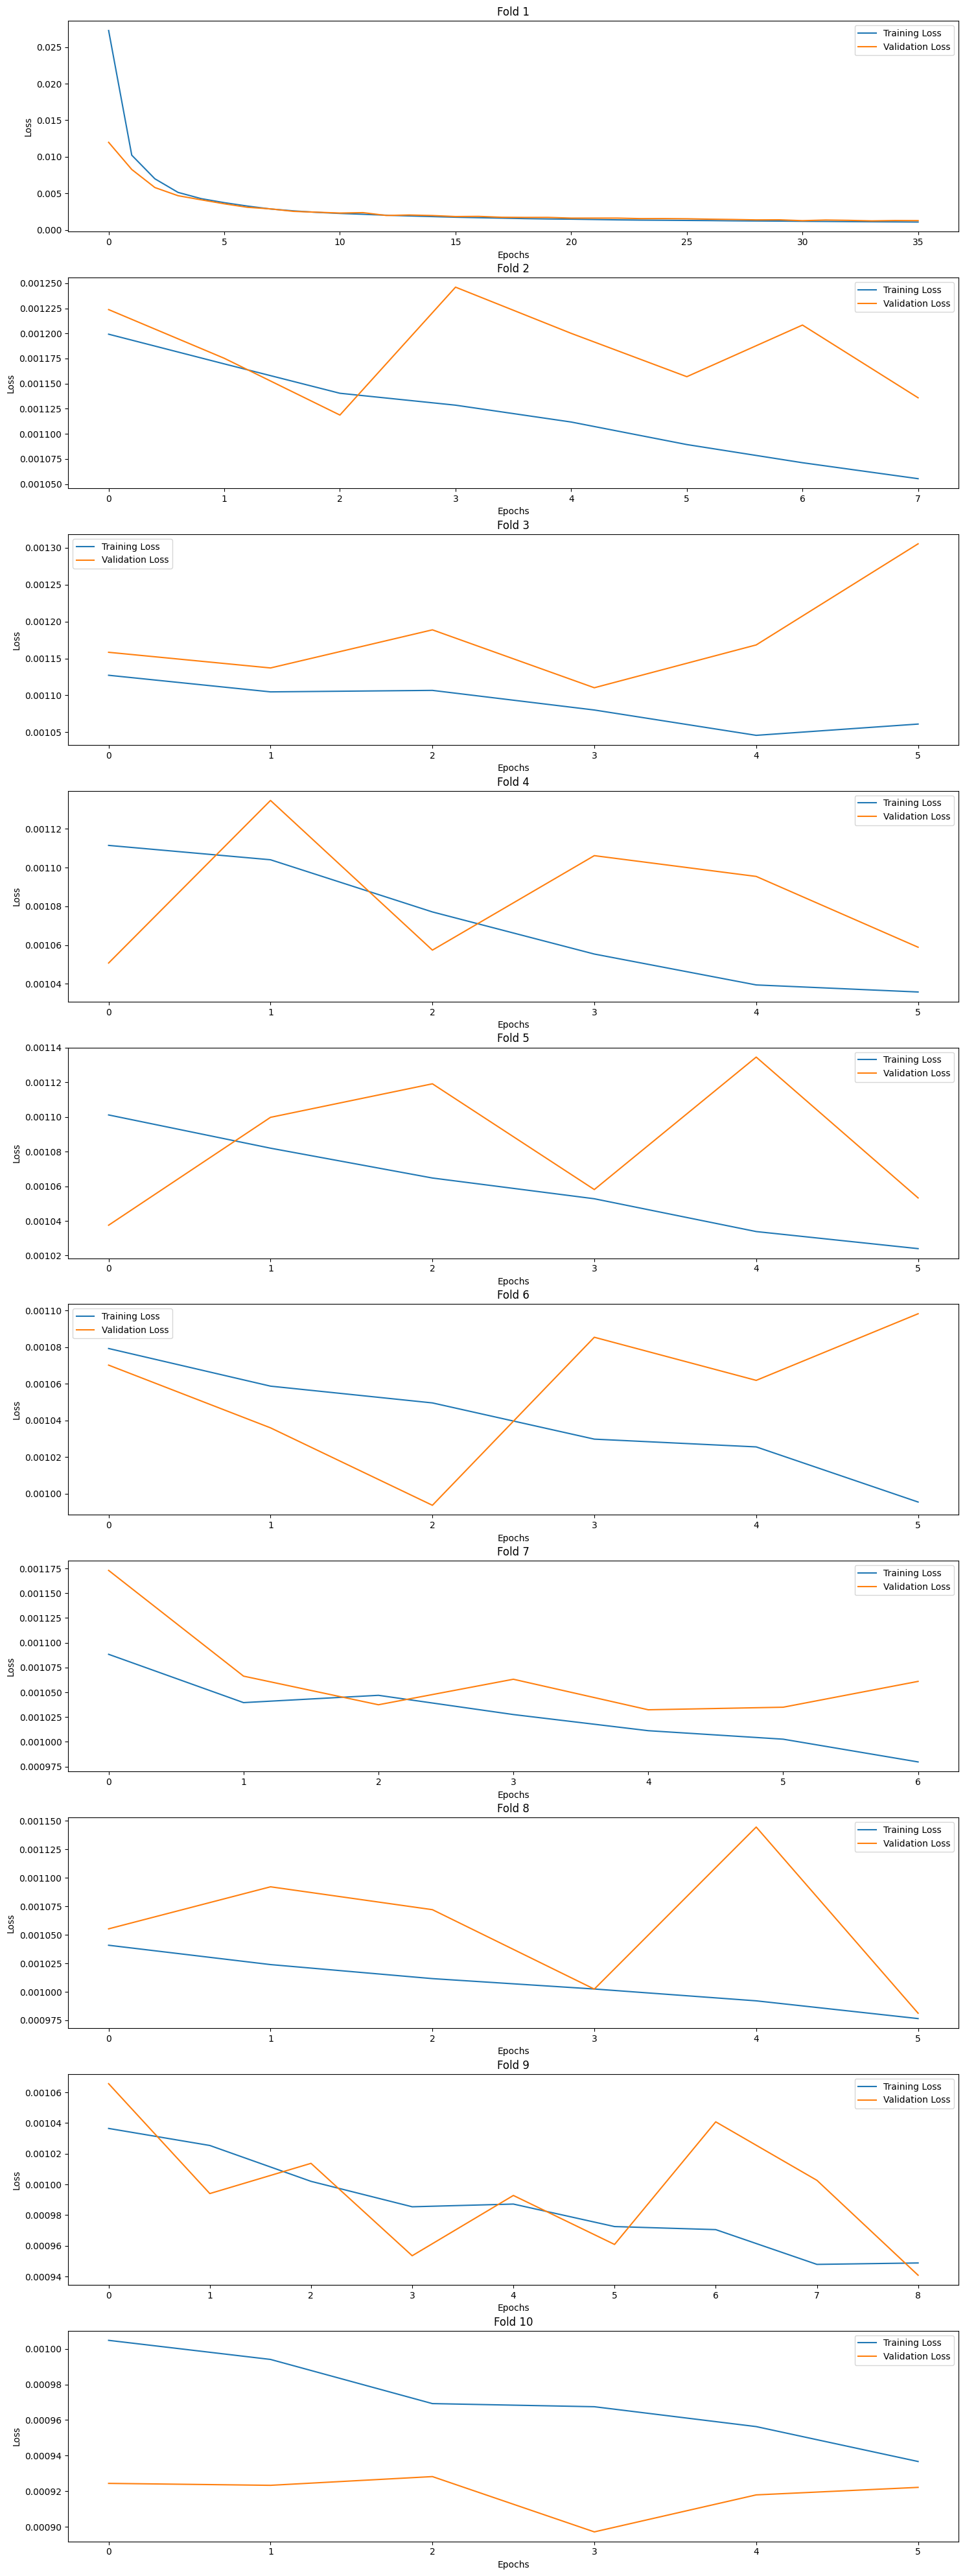


Training and validation loss telah disimpan di training_kfold_results.png


In [ ]:
# List untuk menyimpan hasil
scalers = []
training_losses = []
validation_losses = []

# Membuat subplot sesuai jumlah fold
fig, axes = plt.subplots(n_splits, 1, figsize=(15, 4 * n_splits))
fig.tight_layout(pad=3.0)

# Jika hanya ada 1 fold, ubah menjadi list untuk konsistensi
if n_splits == 1:
    axes = [axes]

# Training dan evaluasi untuk setiap fold
for fold_idx, (train_index, val_index) in enumerate(kfold.split(X)):
    X_train, X_val = X[train_index], X[val_index]

    # Normalisasi data
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    scalers.append(scaler)

    # Melatih model
    history = autoencoder.fit(
        X_train_scaled, X_train_scaled,
        epochs=100,
        batch_size=32,
        validation_data=(X_val_scaled, X_val_scaled),
        verbose=0,
        callbacks=[early_stopping]
    )

    # Menyimpan riwayat loss untuk plotting
    axes[fold_idx].plot(history.history['loss'], label='Training Loss')
    axes[fold_idx].plot(history.history['val_loss'], label='Validation Loss')
    axes[fold_idx].set_title(f"Fold {fold_idx + 1}")
    axes[fold_idx].set_xlabel('Epochs')
    axes[fold_idx].set_ylabel('Loss')
    axes[fold_idx].legend()

    # Evaluasi data training
    train_loss = autoencoder.evaluate(X_train_scaled, X_train_scaled, verbose=0)
    training_losses.append(train_loss)

    # Evaluasi data validasi
    val_loss = autoencoder.evaluate(X_val_scaled, X_val_scaled, verbose=0)
    validation_losses.append(val_loss)

    print(f'Fold {fold_idx + 1}: Training MSE = {train_loss:.4f}, Validation MSE = {val_loss:.4f}')

# Menampilkan plot
plt.show()

# Menyimpan plot ke file
fig.savefig("training_kfold_results.png", dpi=300, bbox_inches='tight')
print("\nTraining and validation loss telah disimpan di training_kfold_results.png")

In [ ]:
# Generate encodings after scaling
X_scaled = np.zeros_like(X, dtype=np.float64)

for fold_idx, (train_index, val_index) in enumerate(kfold.split(X)):
    X_fold = X[val_index]
    scaler = scalers[fold_idx]
    X_scaled[val_index] = scaler.transform(X_fold)

perfume_encodings = autoencoder.predict(X_scaled)

636/636 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [ ]:
df[features]

,fresh,coconut,cinnamon,smoky,conifer,brown scotch tape,rose,tennis ball,almond,metallic,...,violet,soapy,coca-cola,foresty,wine,woody,sand,herbal,mineral,white floral
0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.671873,0.0,0.000000,0.0,0.0
1,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.490950,0.0,0.0
2,0.476385,0.0,0.000000,0.0,0.000000,0.0,0.870907,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.490018,0.0,0.000000,0.0,0.0
3,0.000000,0.0,0.680306,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.794398,0.0,0.000000,0.0,0.0
4,0.000000,0.0,0.843546,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20331,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.835001,0.0,0.457498,0.0,0.0
20332,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
20333,0.000000,0.0,0.000000,0.0,0.479269,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
20334,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.838462,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0


# **Save The Model**

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Simpan model ke dalam Google Drive



Mounted at /content/drive


In [ ]:
# Simpan autoencoder
autoencoder.save('/content/drive/My Drive/TA/autoencoder_model.h5')

# Simpan scaler dari fold tertentu, misalnya fold 0
joblib.dump(scalers[9], '/content/drive/My Drive/TA/scaler.pkl')


['/content/drive/My Drive/TA/scaler.pkl']

# **Compute Similarity**

In [ ]:
# Recommendation function
def recommend_perfumes(input_encoding):
    similarities = cosine_similarity(input_encoding, perfume_encodings)

    recommendations_df = pd.DataFrame({
        'Similarity Score': similarities[0]
    })

    # Concatenate the similarity scores with the original DataFrame
    recommendations_df = pd.concat([recommendations_df, df.reset_index()], axis=1)
    return recommendations_df.sort_values(by='Similarity Score', ascending=False)

# **Get Recommendations**

In [ ]:
# Load autoencoder dan encoder
autoencoder = load_model('/content/drive/My Drive/TA/autoencoder_model.h5')
scaler = joblib.load('/content/drive/My Drive/TA/scaler.pkl')

perfume_encodings = autoencoder.predict(X_scaled)
perfume_encodings

636/636 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


array([[7.45200523e-05, 1.72671804e-03, 1.08314529e-02, ...,
        3.08078306e-04, 2.93481517e-05, 6.43934729e-03],
       [2.15194439e-13, 9.27161364e-06, 8.58796921e-05, ...,
        4.95124668e-01, 4.12977301e-03, 1.05964579e-02],
       [5.05546033e-01, 5.78000072e-06, 4.97385906e-03, ...,
        7.41361000e-04, 1.97848678e-03, 1.44283585e-02],
       ...,
       [7.67410547e-03, 2.82747642e-05, 9.95242444e-05, ...,
        1.68901291e-02, 5.62871628e-06, 3.26835848e-02],
       [3.54532176e-06, 1.00515044e-05, 1.40984543e-04, ...,
        5.20081143e-04, 3.62268911e-04, 1.43403213e-05],
       [6.94942772e-01, 4.99045290e-03, 2.20304501e-04, ...,
        1.64692253e-02, 8.56587198e-04, 8.67574383e-03]], dtype=float32)

In [ ]:
# Test the function and encodings
query_perfume_index = 7787
recommendations = recommend_perfumes(perfume_encodings[query_perfume_index].reshape(1, -1))
print(f"Encoding for perfume at index {query_perfume_index}:\n{perfume_encodings[query_perfume_index]}")
print("\nTop 10 recommendations:")
recommendations.head(10)

Encoding for perfume at index 7787:
[1.2525245e-04 1.4145816e-03 7.3245130e-05 1.5424434e-04 1.2654261e-04
 1.0415688e-05 1.5737318e-02 4.1505640e-08 3.5152812e-03 2.2041039e-04
 2.2698462e-06 9.7831367e-03 2.6262162e-04 3.1980402e-03 6.1056041e-03
 3.7002878e-06 1.8372029e-04 7.5209886e-03 9.2937819e-07 4.9152377e-06
 8.1655207e-06 2.8933901e-03 2.6457014e-03 1.7171598e-05 8.7586159e-06
 4.3353189e-06 6.2315593e-07 2.1332764e-07 2.5427285e-10 2.7298936e-08
 4.8056418e-01 4.4782627e-03 5.5701312e-05 2.0358067e-04 1.1927071e-03
 1.9677896e-04 5.3850250e-08 4.7144053e-06 1.6004995e-03 1.1731931e-07
 3.5968467e-05 7.4872221e-03 4.7836821e-03 6.7976029e-03 2.3759043e-04
 2.0269956e-04 8.6571369e-03 1.5649976e-03 2.3105989e-04 1.2724399e-05
 3.1840570e-02 6.0391460e-05 3.7918624e-02 1.1709903e-06 3.8685891e-07
 2.4008554e-05 4.6627194e-04 2.2182853e-03 1.0678693e-05 1.5761009e-03
 5.9994605e-08 2.9241224e-11 3.6866130e-08 4.4441294e-06 7.4043525e-03
 8.1587874e-09 2.9777393e-03 1.0630469e-0

,Similarity Score,index,URL,Perfume Name,Gender,Brand,Description,Description Blockquote,Top Notes,Middle Notes,...,violet,soapy,coca-cola,foresty,wine,woody,sand,herbal,mineral,white floral
7787,1.000000,7787,https://www.fragrantica.com/perfume/Maison-Alh...,Floral Bloom Maison Alhambra,for women,Maison Alhambra,Floral Bloom by Maison Alhambra is a Floral Wo...,,,,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000
17739,0.972754,17739,https://www.fragrantica.com/perfume/Coty/Sand-...,Sand & Sable Coty,for women,Coty,Sand & Sable by Coty is a Floral fragrance for...,,,,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000
17437,0.947904,17437,https://www.fragrantica.com/perfume/Jimmy-Choo...,Radiant Tuberose Jimmy Choo,for women,Jimmy Choo,Radiant Tuberose by Jimmy Choo is a Floral fra...,,,,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000
4841,0.943381,4841,https://www.fragrantica.com/perfume/Zara/Royal...,Royale Tubereuse Perfume Oil Zara,for women,Zara,Royale Tubereuse Perfume Oil by Zara is a Flor...,Artisanal scented oil with the noblest and mos...,,,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.859999
463,0.943381,463,https://www.fragrantica.com/perfume/Dior/Dior-...,Dior Passage No.9 Dior,for women,Dior,Dior Passage No.9 by Dior is a Floral fragranc...,Due to the 60th anniversary of the house of Di...,,,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.859999
6627,0.943381,6627,https://www.fragrantica.com/perfume/Frederic-M...,Carnal Flower Hair Mist Frederic Malle,for women and men,Frederic Malle,Carnal Flower Hair Mist by Frederic Malle is a...,,,,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.859999
18325,0.943381,18325,https://www.fragrantica.com/perfume/Goutal/Tub...,Tubereuse Goutal,for women,Goutal,Tubereuse by Goutal is a Floral fragrance for ...,,,,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.859999
8032,0.942030,8032,https://www.fragrantica.com/perfume/Penhaligon...,Gardenia Penhaligon's,for women,Penhaligon's,Gardenia by Penhaligon's is a Floral fragrance...,Gardenia is an English perfume made from the f...,,,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000
9104,0.922609,9104,https://www.fragrantica.com/perfume/Natura/Lun...,Luna Viva Natura,for women,Natura,Luna Viva by Natura is a Chypre fragrance for ...,,,,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000
5517,0.922024,5517,https://www.fragrantica.com/perfume/Avon/A-Mar...,A Marriage Of Jasmine & Tuberose Avon,for women,Avon,A Marriage Of Jasmine & Tuberose by Avon is a ...,,,,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000


In [ ]:
# Pastikan user_input adalah array NumPy dan reshape ke (1, -1)
input_encoding = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.64999919500072, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.85999935600058, 0.0, 0.0, 0.0]).reshape(1, -1)

# Dapatkan rekomendasi
recommendations = recommend_perfumes(input_encoding)

# Tampilkan hasil teratas
print(recommendations[['Similarity Score']].head(10))

       Similarity Score
9967           0.522507
12836          0.514400
13514          0.514400
10248          0.514400
1654           0.514400
18641          0.514400
10138          0.514400
18642          0.481984
2704           0.439103
2660           0.439031


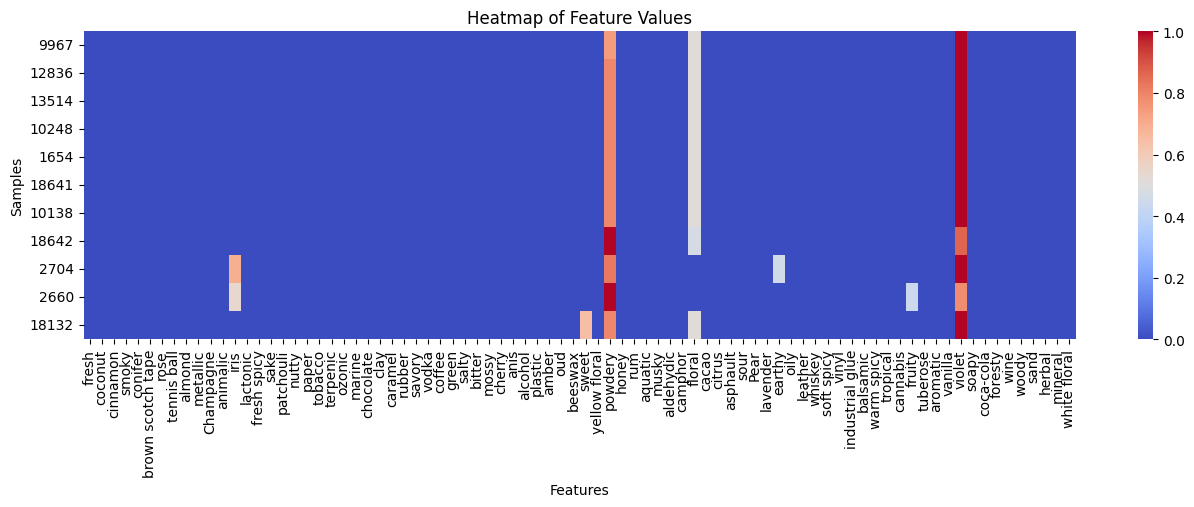

In [ ]:
data_for_heatmap = recommendations[features].head(11)

plt.figure(figsize=(16, 4))
sns.heatmap(
    data_for_heatmap,
    cmap="coolwarm",
    annot=False,
    cbar=True,
    xticklabels=True,
    yticklabels=True
)

plt.title("Heatmap of Feature Values")
plt.xlabel("Features")
plt.ylabel("Samples")
plt.show()

In [ ]:
recommendations[features]

,fresh,coconut,cinnamon,smoky,conifer,brown scotch tape,rose,tennis ball,almond,metallic,...,violet,soapy,coca-cola,foresty,wine,woody,sand,herbal,mineral,white floral
9967,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
12836,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
13514,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
10248,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
1654,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15512,0.703065,0.0,0.000000,0.656776,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.892739,0.0,0.0,0.0,0.875805
5226,0.650000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.705515,0.0,0.0,0.0,0.000000
5225,0.649998,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.720001,0.0,0.0,0.0,0.000000
10739,0.000000,0.0,0.655934,0.000000,0.0,0.0,0.0,0.0,0.0,0.477967,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000


# **Evaluate Result**

In [ ]:
# --- Evaluation Metrics ---
# Function to calculate DCG
def dcg_at_k(actual, predicted, k=10):
    dcg = 0.0
    for i, p in enumerate(predicted[:k]):
        if p in actual:
            dcg += 1 / np.log2(i + 2)  # i+2 to handle rank starting at 1
    return dcg

# Function to calculate NDCG
def ndcg_at_k(actual, predicted, k=10):
    dcg = dcg_at_k(actual, predicted, k)
    idcg = dcg_at_k(actual, actual[:k])  # Ideal DCG
    return dcg / idcg if idcg > 0 else 0.0

def average_precision(actual, predicted, k=10):
    if not actual:
        return 0.0

    precision_values = []
    num_rel = 0
    for i, p in enumerate(predicted):
      if i >= k:
        break
      if p in actual:
        num_rel += 1
        precision_values.append(num_rel / (i + 1))

    if not precision_values:
        return 0.0
    return sum(precision_values) / min(len(actual), k)

def reciprocal_rank(actual, predicted, k=10):
    for i, item in enumerate(predicted):
        if i >= k:
            break
        if item in actual:
            return 1 / (i + 1)
    return 0.0

# Calculate Mean metrics
def calculate_mean_metrics(perfume_encodings, df, relevant_docs, k=10):
    mean_ndcg = 0.0
    mean_ap = 0.0
    mean_rr = 0.0
    num_queries = len(relevant_docs)

    for query_id, relevant_items in relevant_docs.items():
        if query_id >= len(perfume_encodings):
            continue

        query_encoding = perfume_encodings[query_id].reshape(1, -1)
        recommendations = recommend_perfumes(query_encoding)
        recommended_items = recommendations['index'].tolist()

        # Calculate metrics for this query
        ndcg = ndcg_at_k(relevant_items, recommended_items, k)
        avg_prec = average_precision(relevant_items, recommended_items, k)
        recip_rank = reciprocal_rank(relevant_items, recommended_items, k)

        mean_ndcg += ndcg
        mean_ap += avg_prec
        mean_rr += recip_rank

        print(f"Query ID: {query_id}")
        print(f"  NDCG@{k}: {ndcg:.4f}")
        print(f"  Average Precision: {avg_prec:.4f}")
        print(f"  Reciprocal Rank: {recip_rank:.4f}")

    if num_queries == 0:
      return 0.0, 0.0, 0.0
    return mean_ndcg/num_queries, mean_ap/num_queries, mean_rr/num_queries


In [ ]:
relevant_docs = {
    6477:[12498, 11592, 6544, 7424, 15086, 7337, 10917, 11349, 11941,4158],
    7193:[17141, 9843, 9881, 16092, 18317, 16331, 10455, 4597, 5395, 6086],
    7:[6011, 6576, 10948, 10337, 1104, 10962, 6207, 10316, 19100, 8283],
    1602:[11067, 9577, 8225, 17450, 2846, 2436, 2773, 5774, 7802, 3735],
    4674:[4675, 17604, 3333, 3329, 2936, 3200, 17650, 1164, 2217, 3352],
    17604:[2936, 2217, 8758, 17583, 9900, 1164, 10326, 4070, 228, 3387],
    13582:[18505, 19689, 7656, 18922, 8696, 11039, 6047, 18506, 17085, 16884],
    108:[8316, 18235, 13916, 562, 8479, 11647, 4171, 11167, 482, 2018],
    17697:[12367, 10157, 13939, 5985, 13940, 13347, 12646, 18429, 14140, 12225],
    7787:[9297, 9104, 5517, 17739, 12966, 8032, 8157, 17437, 4150, 2676],
    1479:[12183, 11059, 15003, 20084, 16534, 13978, 16382, 6990, 12827, 14765]
}

# Evaluate the model and print the results
mean_ndcg, mean_ap, mean_rr = calculate_mean_metrics(perfume_encodings, df, relevant_docs, k=10)
print("\n------------------------------------------\n")
print(f"Mean NDCG@10: {mean_ndcg:.4f}")
print(f"Mean Average Precision (MAP): {mean_ap:.4f}")
print(f"Mean Reciprocal Rank (MRR): {mean_rr:.4f}")

Query ID: 6477
  NDCG@10: 0.5431
  Average Precision: 0.3630
  Reciprocal Rank: 0.5000
Query ID: 7193
  NDCG@10: 0.7799
  Average Precision: 0.7071
  Reciprocal Rank: 0.5000
Query ID: 7
  NDCG@10: 0.5806
  Average Precision: 0.4407
  Reciprocal Rank: 0.5000
Query ID: 1602
  NDCG@10: 0.6429
  Average Precision: 0.5078
  Reciprocal Rank: 0.5000
Query ID: 4674
  NDCG@10: 0.6469
  Average Precision: 0.5185
  Reciprocal Rank: 0.5000
Query ID: 17604
  NDCG@10: 0.5709
  Average Precision: 0.4150
  Reciprocal Rank: 0.5000
Query ID: 13582
  NDCG@10: 0.7105
  Average Precision: 0.5985
  Reciprocal Rank: 0.5000
Query ID: 108
  NDCG@10: 0.5716
  Average Precision: 0.4181
  Reciprocal Rank: 0.5000
Query ID: 17697
  NDCG@10: 0.5716
  Average Precision: 0.4181
  Reciprocal Rank: 0.5000
Query ID: 7787
  NDCG@10: 0.4482
  Average Precision: 0.2486
  Reciprocal Rank: 0.5000
Query ID: 1479
  NDCG@10: 0.8611
  Average Precision: 0.7571
  Reciprocal Rank: 1.0000

------------------------------------------


In [ ]:
def calculate_mean_metrics_with_dataframe(perfume_encodings, relevant_docs, k=10):
    results = []

    mean_ndcg = 0.0
    mean_ap = 0.0
    mean_rr = 0.0
    num_queries = len(relevant_docs)

    for query_id, relevant_indices in relevant_docs.items():
        if query_id >= len(perfume_encodings):
            continue

        query_encoding = perfume_encodings[query_id].reshape(1, -1)
        recommendations = recommend_perfumes(query_encoding)
        recommended_indices = recommendations['index'].tolist()

        # Calculate metrics
        ndcg = ndcg_at_k(relevant_indices, recommended_indices, k)
        avg_prec = average_precision(relevant_indices, recommended_indices, k)
        recip_rank = reciprocal_rank(relevant_indices, recommended_indices, k)

        # Tambahkan hasil ke daftar
        results.append({
            "Query ID": query_id,
            "Expected Output": ", ".join(map(str, relevant_indices)),
            "Output": ", ".join(map(str, recommended_indices)),
            "NDCG": round(ndcg, 4),
            "MAP": round(avg_prec, 4),
            "MRR": round(recip_rank, 4)
        })

        mean_ndcg += ndcg
        mean_ap += avg_prec
        mean_rr += recip_rank

    if num_queries > 0:
        mean_ndcg /= num_queries
        mean_ap /= num_queries
        mean_rr /= num_queries

    # Tambahkan baris rata-rata keseluruhan
    results.append({
        "Query ID": "Average",
        "Expected Output": "-",
        "Output": "-",
        "NDCG": round(mean_ndcg, 4),
        "MAP": round(mean_ap, 4),
        "MRR": round(mean_rr, 4)
    })

    return pd.DataFrame(results)

results_df = calculate_mean_metrics_with_dataframe(perfume_encodings, relevant_docs, k=10)
results_df

,Query ID,Expected Output,Output,NDCG,MAP,MRR
0,6477,"12498, 11592, 6544, 7424, 15086, 7337, 10917, ...","6477, 12498, 11592, 6666, 6544, 6277, 7424, 11...",0.5431,0.3630,0.5000
1,7193,"17141, 9843, 9881, 16092, 18317, 16331, 10455,...","7193, 9881, 17141, 9843, 16092, 18317, 10455, ...",0.7799,0.7071,0.5000
2,7,"6011, 6576, 10948, 10337, 1104, 10962, 6207, 1...","7, 6011, 10962, 10948, 1104, 6207, 19100, 6206...",0.5806,0.4407,0.5000
3,1602,"11067, 9577, 8225, 17450, 2846, 2436, 2773, 57...","1602, 11067, 9577, 8225, 17450, 3735, 18601, 5...",0.6429,0.5078,0.5000
4,4674,"4675, 17604, 3333, 3329, 2936, 3200, 17650, 11...","4674, 4675, 3329, 17604, 2936, 3333, 3200, 228...",0.6469,0.5185,0.5000
5,17604,"2936, 2217, 8758, 17583, 9900, 1164, 10326, 40...","17604, 2936, 8758, 1164, 228, 4070, 3391, 1517...",0.5709,0.4150,0.5000
6,13582,"18505, 19689, 7656, 18922, 8696, 11039, 6047, ...","13582, 18505, 8696, 19689, 18506, 6047, 17085,...",0.7105,0.5985,0.5000
7,108,"8316, 18235, 13916, 562, 8479, 11647, 4171, 11...","108, 8316, 18235, 11647, 8479, 6771, 13916, 48...",0.5716,0.4181,0.5000
8,17697,"12367, 10157, 13939, 5985, 13940, 13347, 12646...","17697, 12367, 10157, 5985, 13940, 6439, 12646,...",0.5716,0.4181,0.5000
9,7787,"9297, 9104, 5517, 17739, 12966, 8032, 8157, 17...","7787, 17739, 17437, 4841, 463, 6627, 18325, 80...",0.4482,0.2486,0.5000
